In [1]:
] activate .

  Activating project at `~/.julia/dev/CoverageControllers/examples`


In [2]:
] st

Status `~/.julia/dev/CoverageControllers/examples/Project.toml`
  [a198fc80] CoverageControllers v1.0.0-DEV `..`
⌃ [91a5bcdd] Plots v1.40.7
  [92933f4c] ProgressMeter v1.10.2
  [90137ffa] StaticArrays v1.9.7
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [3]:
using Revise

In [4]:
using CoverageControllers, Plots, LinearAlgebra, ProgressMeter

## Create a Domain

In [35]:
# consider a 2km x 2 km domain to explore
# length units: meters
# time units: seconds

o = (0.0, 0.0)
dx = (0.0211, 0.02) .* 1000
L = (2.0, 2.0) .* 1000 # km
grid = Grid(o, dx, L)

Grid(origin=(0.0, 0.0), spacing=(21.1, 20.0), N=(96, 101))


In [36]:
typeof(grid)

Grid{2, Float64, FFTW.r2rFFTWPlan{Float64, Vector{Int32}, false, 2, Tuple{Int64, Int64}}}

In [37]:
# get some details about the domain

In [38]:
CoverageControllers.center(grid)

(1002.2500000000001, 1000.0)

In [39]:
lengths(grid)

(2004.5000000000002, 2000.0)

In [40]:
axes(grid, 1)

0.0:21.1:2004.5

In [41]:
axes(grid)

(0.0:21.1:2004.5, 0.0:20.0:2000.0)

In [42]:
# convert from positions to indices and vice versa

In [80]:
randpos = (rand(), rand()) .* 2000

@show randpos 
ind = pos2ind(grid, randpos)
@show ind
pos = ind2pos(grid, ind)
@show pos;

randpos = (853.7500392139611, 1314.8039897058168)
ind = CartesianIndex(41, 67)
pos = (844.0, 1320.0)


## Create a target spatial distribution

In [16]:
tsd_peaks = [
    (1000.0, 1200., 100.0), 
    (1300., 800., 100.0), 
    (1500., 1200., 50.0), 
]
function tsd_function(position, peaks)
    return sum( exp( - norm( (position .- (peak[1:2])) ./ peak[3])) for peak in peaks)
end
    
tsd = fill(p -> tsd_function(p, tsd_peaks), grid);

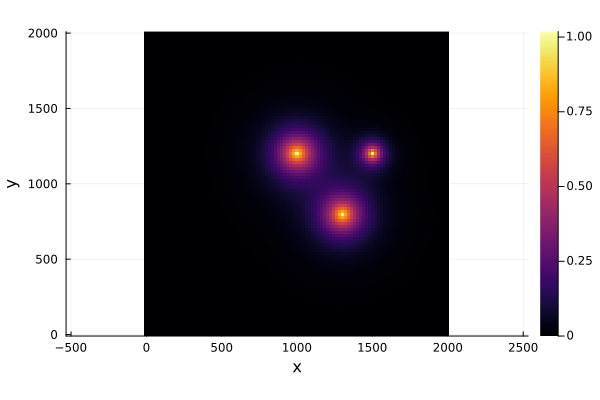

In [17]:
# plotting a tsd is easy 
plot(grid, tsd)

## Compute the Ergodic Control Input

In [18]:
# suppose we have the past trajectory of a robot
traj = [(900., 800.), (920., 820.)]

2-element Vector{Tuple{Float64, Float64}}:
 (900.0, 800.0)
 (920.0, 820.0)

In [19]:
# we can convert it to a spatial distribution
spatial_traj = CoverageControllers.trajectory_map(grid, traj);

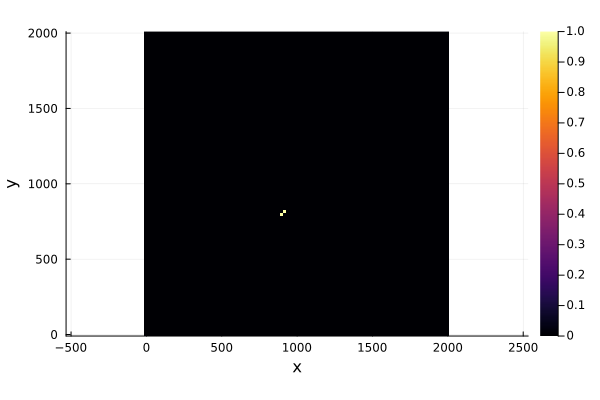

In [20]:
# again, we can plot it directly
plot(grid, spatial_traj)

In [21]:
# let us try to compute the ergodic controllers

In [22]:
pos = last(traj)

(920.0, 820.0)

In [23]:
# the descent direction is essentially the negative of the desired direction for exploration
CoverageControllers.ergodic_descent_direction(grid, pos, tsd, traj)

(-0.7230761805175052, -0.5587051036035288)

In [24]:
# the controller depends on the robot type. 
# we provide SingleIntegrator and DoubleIntegrator type robots:
umax = 5.0 # m / s
robot = CoverageControllers.SingleIntegrator(umax) # max speed in length_units/time_units

SingleIntegrator{Float64}(5.0)

In [25]:
# we can now compute the control input
CoverageControllers.ergodic_controller(grid, robot, pos, tsd, traj)

(3.956519203510272, 3.057115600080318)

## Define a Boundary

In [26]:
# create a boundary domain (that is non-convex)
function star_boundary(center, inner_radius, outer_radius)

    cx, cy = center
    ri = inner_radius
    ro = outer_radius
    inner_ring = [ (cx + ri * sin(θ + π), cy + ri * cos(θ + π)) for θ in range(0, -2π, length=6)]
    outer_ring = [ (cx + ro * sin(θ + π + 2π/12), cy + ro * cos(θ + π + 2π/12)) for θ in range(0, -2π, length=6)]
    boundary_pts = NTuple{2, Float64}[]
    for i=1:5
        push!(boundary_pts, outer_ring[i])
        push!(boundary_pts, inner_ring[i])
    end

    # PolygonBoundary creates a boundary by following a list of points. 
    # the interior is defined by following the lineboundary clockwise.
    return boundary = CoverageControllers.PolygonBoundary(boundary_pts, closed=true)
end

boundary_star = star_boundary( (1000., 1000.), 500., 900.)

# you can also get just the outer boundary using `GridBoundary`
boundary_grid = CoverageControllers.GridBoundary(grid)

# essentially a vector of LineBoundary structs
boundary = [boundary_star..., boundary_grid...]

14-element Vector{CoverageControllers.LineBoundary{2, Float64}}:
 CoverageControllers.LineBoundary{2, Float64}((550.0000000000002, 220.57713659400508), (1000.0000000000001, 500.0))
 CoverageControllers.LineBoundary{2, Float64}((1000.0000000000001, 500.0), (1602.2175457229725, 331.16965707034524))
 CoverageControllers.LineBoundary{2, Float64}((1602.2175457229725, 331.16965707034524), (1475.5282581475767, 845.4915028125263))
 CoverageControllers.LineBoundary{2, Float64}((1475.5282581475767, 845.4915028125263), (1822.1909118783408, 1366.0629787682203))
 CoverageControllers.LineBoundary{2, Float64}((1822.1909118783408, 1366.0629787682203), (1293.8926261462366, 1404.5084971874737))
 CoverageControllers.LineBoundary{2, Float64}((1293.8926261462366, 1404.5084971874737), (905.9243830591118, 1895.0697058314458))
 CoverageControllers.LineBoundary{2, Float64}((905.9243830591118, 1895.0697058314458), (706.1073738537634, 1404.5084971874737))
 CoverageControllers.LineBoundary{2, Float64}((706.107373

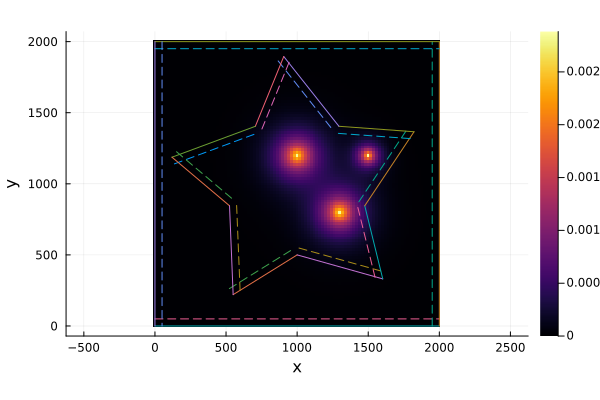

In [27]:
# plot the boundary 
plot(grid, tsd)
for b in boundary
    plot!(b; dist=50.0)
end
plot!(aspect_ratio=:equal)

## Run the simulation

In [32]:
# robot state
state = (900.0, 800.0) 

# how far must the robot be to have no speed constraints applied
boundary_correction_distance = 50.0

# define the past trajectory
traj = [CoverageControllers.position(robot, state), ]

# create time domain
Δt = 2.0 # seconds
tmax = 15000.0 # seconds
ts = 0.0:Δt:tmax

# run the simulation
@showprogress for t in ts
    # compute the control input 
    u = CoverageControllers.ergodic_controller(
        grid,  # grid domain
        robot, # robot type
        state, # current robot state
        tsd,   # pass in the target spatial distribution
        traj;  # the past trajectory as a list of points
        boundaries = boundary, # all the boundaries
        boundary_correction_distance=boundary_correction_distance 
    )

    # use the dynamics to determine the new state of the robot
    state = CoverageControllers.dynamics(robot, state, u, Δt)

    # append the position to the past trajectory
    push!(traj, CoverageControllers.position(robot, state))
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


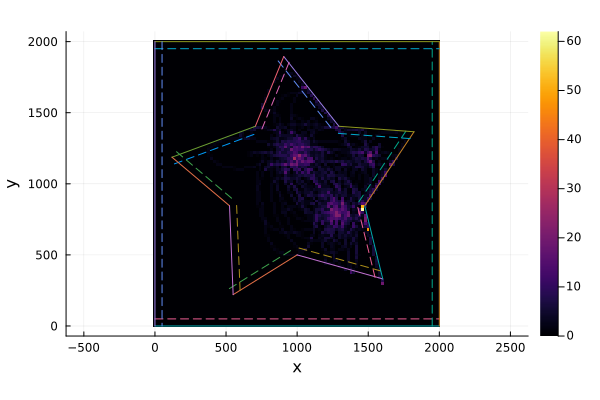

In [33]:
m = CoverageControllers.trajectory_map(grid, traj)
plot(grid, m)
for b in boundary
    plot!(b; dist=boundary_correction_distance)
end
plot!()

[ Info: Saved animation to /Users/devanshagrawal/.julia/dev/CoverageControllers/examples/tmp.gif


Plots.AnimatedGif("/Users/devanshagrawal/.julia/dev/CoverageControllers/examples/tmp.gif")
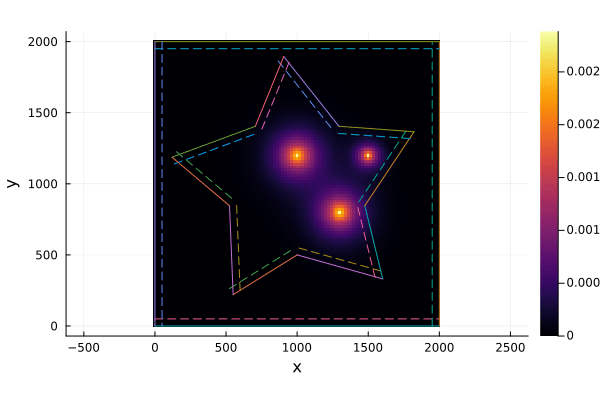

In [34]:
@gif for k = Int.(floor.(range(1, length(traj), length=60)))
    xs = [traj[i][1] for i=1:k]
    ys = [traj[i][2] for i=1:k]

    plot(grid, tsd)
    for b in boundary
        plot!(b; dist=boundary_correction_distance) 
    end
    plot!(xs, ys, label=false)
    
end